In [121]:
import os
import re
import numpy as np
import pandas as pd
from scipy.stats import shapiro, levene, f_oneway, kruskal
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import scikit_posthocs as sp

In [122]:
def parse_file(file_path):
    with open(file_path, 'r', encoding="utf-8") as f:
        content = f.read()

    blocks = re.split(r"Performance counter stats for 'system wide':", content)
    rows = []

    # From this point on, GPT was used as a programming aid. The format of the results file was given as context.
    # The regular expressions are copied directly from the language model
    def clean_float(s):
        return float(s.replace('\u202F', '').replace(' ', '').replace(',', '.'))

    def clean_int(s):
        return int(s.replace('\u202F', '').replace(' ', ''))

    # Here, a combination of my own work and GPT was used
    for block in blocks[1:]:
        pkg_match = re.search(r"([\d,]+) Joules power/energy-pkg/", block)
        core_match = re.search(r"([\d,]+) Joules power/energy-cores/", block)
        cycles_match = re.search(r"([\d\s\u202F]+) +cycles", block)
        instr_match = re.search(r"([\d\s\u202F]+) +instructions", block)
        cache_ref_match = re.search(r"([\d\s\u202F]+) +cache-references", block)
        cache_miss_match = re.search(r"([\d\s\u202F]+) +cache-misses", block)
        cs_match = re.search(r"([\d\s\u202F]+) +cs", block)
        migrations_match = re.search(r"([\d\s\u202F]+) +migrations", block)
        pf_match = re.search(r"([\d\s\u202F]+) +page-faults", block)

        data = {
            "energy_pkg": clean_float(pkg_match.group(1)),
            "energy_cores": clean_float(core_match.group(1)),
            "cycles": clean_int(cycles_match.group(1)),
            "instructions": clean_int(instr_match.group(1)),
            "cache_references": clean_int(cache_ref_match.group(1)),
            "cache_misses": clean_int(cache_miss_match.group(1)),
            "cs": clean_int(cs_match.group(1)),
            "migrations": clean_int(migrations_match.group(1)),
            "page_faults": clean_int(pf_match.group(1)),
        }
        rows.append(data)

    return rows


In [123]:
all_rows = []

# Create dataframe for main tests

test_file_names = [
    "test_leo_skeleton_base_empty.txt",
    "test_leo_skeleton_base_long.txt",
    "test_leo_skeleton_base_medium.txt",
    "test_leo_skeleton_change_empty.txt",
    "test_leo_skeleton_change_long.txt", 
    "test_leo_skeleton_change_medium.txt", 
    "test_leo_skeleton_change+logging_long.txt",
    "test_leo_skeleton_change+logging_medium.txt",
    "test_leo_skeleton_change+logging_empty.txt",
    "test_mu_skeleton_base_empty.txt",
    "test_mu_skeleton_base_long.txt",
    "test_mu_skeleton_base_medium.txt",
    "test_mu_skeleton_change_empty.txt",
    "test_mu_skeleton_change_long.txt",
    "test_mu_skeleton_change_medium.txt",
    "test_mu_skeleton_change+logging_long.txt",
    "test_mu_skeleton_change+logging_medium.txt",
    "test_mu_skeleton_change+logging_empty.txt",
    "test_novelWriter_skeleton_base_empty.txt",
    "test_novelWriter_skeleton_base_long.txt",
    "test_novelWriter_skeleton_base_medium.txt",
    "test_novelWriter_skeleton_change_empty.txt",
    "test_novelWriter_skeleton_change_long.txt",
    "test_novelWriter_skeleton_change_medium.txt",
    "test_novelWriter_skeleton_change+logging_long.txt",
    "test_novelWriter_skeleton_change+logging_medium.txt",
    "test_novelWriter_skeleton_change+logging_empty.txt"
]
for file in test_file_names:
    parsed = parse_file(file)
    test_name = os.path.basename(file).replace(".txt","")
    for idx, row in enumerate(parsed,1):
        row["test"] = test_name
        row["run"] = idx
        all_rows.append(row)
original_df = pd.DataFrame(all_rows)

# GPT written below:
# Add new columns for app, variant and size grouping
original_df[['app', 'variant', 'size']] = (
    original_df['test'].str.extract(r'test_(?P<app>[a-zA-Z]+)_skeleton_(?P<variant>[^_]+)_(?P<size>empty|medium|long)')
)

print(original_df.head(10))

   energy_pkg  energy_cores      cycles  instructions  cache_references  \
0       58.15          2.62  1205632822     420613620          47533145   
1       45.54          2.41  1172328882     358697847          44816818   
2       53.22          2.33  1145813786     363630064          44353035   
3       56.20          2.78  1288981070     374030561          47821323   
4       61.27          2.63  1296263687     541997216          47250695   
5       62.07          2.42  1166862379     360993520          45594577   
6       55.56          2.36  1164006373     352163462          44268202   
7       58.49          2.41  1240766886     434766567          45593474   
8       55.31          2.80  1303753001     554700304          46004282   
9       56.28          2.50  1195266861     373586452          45852171   

   cache_misses     cs  migrations  page_faults                          test  \
0      23117788  11333          66         1120  test_leo_skeleton_base_empty   
1      22199

In [124]:
all_rows = []

# Create dataframe for control tests

control_file_names = [
    "control_test_empty.txt",
    "control_test_medium.txt",
    "control_test_long.txt"
]
for file in control_file_names:
    parsed = parse_file(file)
    test_name = os.path.basename(file).replace(".txt","")
    for idx, row in enumerate(parsed,1):
        row["test"] = test_name
        row["run"] = idx
        all_rows.append(row)
control_df = pd.DataFrame(all_rows)


control_df["size"] = control_df["test"].str.extract(r'_(empty|medium|long)$', expand=False)


In [125]:
test_df = original_df.copy(deep=True)

# Subtract control from each test
for m in metrics:
    test_df[m] -= test_df["size"].map(control_means[m])

test_df

,energy_pkg,energy_cores,cycles,instructions,cache_references,cache_misses,cs,migrations,page_faults,test,run,app,variant,size
0,10.382667,0.057667,-6.404795e+07,-1.221639e+08,4.056103e+06,1786670.6,1090.6,-4.233333,-154.366667,test_leo_skeleton_base_empty,1,leo,base,empty
1,-2.227333,-0.152333,-9.735189e+07,-1.840797e+08,1.339776e+06,868690.6,810.6,-22.233333,-1073.366667,test_leo_skeleton_base_empty,2,leo,base,empty
2,5.452667,-0.232333,-1.238670e+08,-1.791475e+08,8.759928e+05,845492.6,685.6,1.766667,-401.366667,test_leo_skeleton_base_empty,3,leo,base,empty
3,8.432667,0.217667,1.930030e+07,-1.687470e+08,4.344281e+06,2226613.6,1283.6,-8.233333,-1098.366667,test_leo_skeleton_base_empty,4,leo,base,empty
4,13.502667,0.067667,2.658292e+07,-7.803483e+05,3.773653e+06,1537451.6,1333.6,15.766667,1043.633333,test_leo_skeleton_base_empty,5,leo,base,empty
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
805,12.672667,-0.112333,-1.128239e+08,-1.770337e+08,1.409166e+06,856383.6,789.6,-0.233333,-1034.366667,test_novelWriter_skeleton_change+logging_empty,26,novelWriter,change+logging,empty
806,19.142667,0.107667,-1.401408e+08,-1.954753e+08,9.695078e+05,709814.6,518.6,-16.233333,-487.366667,test_novelWriter_skeleton_change+logging_empty,27,novelWriter,change+logging,empty
807,6.012667,0.197667,3.984015e+07,-2.507989e+06,2.973705e+06,1819314.6,1070.6,23.766667,913.633333,test_novelWriter_skeleton_change+logging_empty,28,novelWriter,change+logging,empty
808,6.332667,-0.112333,-9.368674e+07,-2.088555e+08,3.761258e+05,952492.6,641.6,10.766667,-1186.366667,test_novelWriter_skeleton_change+logging_empty,29,novelWriter,change+logging,empty


In [126]:
overall_pkg = control_df['energy_pkg'].agg(['mean', 'min', 'max'])

per_size_pkg = (control_df.groupby('size')['energy_pkg'].agg(['mean', 'min', 'max']))

overall_pkg

mean    48.193556
min     39.190000
max     71.530000
Name: energy_pkg, dtype: float64

In [127]:
# Initial code based off: https://www.geeksforgeeks.org/detect-and-remove-the-outliers-using-python/
# Author and ChatGPT was used to fix initial problems in this function
def drop_iqr_outliers(df, value_col='energy_pkg', by='test', k=1.5):
    keep_idx = []
    for _, grp in df.groupby(by):
        q1  = grp[value_col].quantile(0.25)
        q3  = grp[value_col].quantile(0.75)
        iqr = q3 - q1
        lo, hi = q1 - k*iqr, q3 + k*iqr
        keep_idx.extend(grp[(grp[value_col] >= lo) & (grp[value_col] <= hi)].index)
    return df.loc[keep_idx]

before = len(test_df)
test_df = drop_iqr_outliers(test_df, value_col='energy_pkg', by='test')
after  = len(test_df)

print(f"Outlier removal: dropped {before - after} rows "
      f"({after}/{before} observations kept).")

Outlier removal: dropped 15 rows (795/810 observations kept).


In [129]:
before = len(control_df)
control_df = drop_iqr_outliers(control_df, value_col='energy_pkg', by='test')
after  = len(control_df)

print(f"Outlier removal: dropped {before - after} rows "
      f"({after}/{before} observations kept).")

metrics = [c for c in control_df.columns if c not in ("test", "run", "size")]

control_means = control_df.groupby("size")[metrics].mean()

print(control_means)

Outlier removal: dropped 2 rows (83/85 observations kept).
        energy_pkg  energy_cores        cycles  instructions  \
size                                                           
empty    47.194138      2.574138  1.276917e+09  5.516951e+08   
long     45.576071      2.432857  1.281177e+09  6.085146e+08   
medium   47.388846      2.459615  1.288785e+09  6.112788e+08   

        cache_references  cache_misses            cs  migrations  page_faults  
size                                                                           
empty       4.355920e+07  2.135911e+07  10269.758621   70.620690  1315.172414  
long        4.528473e+07  2.219904e+07  11390.392857  239.464286  1485.785714  
medium      4.518736e+07  2.229354e+07  11499.846154  233.192308  1461.384615  


In [130]:
#test_df.to_csv("test_results.csv")

In [131]:
# Test for normality - Shapiro-Wilk test

shapiro_results = []
for name, grp in test_df.groupby("test"):
    stat, p = shapiro(grp["energy_pkg"])
    shapiro_results.append({"test": name, "stat": stat, "p": p})
norm_df = pd.DataFrame(shapiro_results)

print(norm_df)

alpha = 0.05

norm_df['is_normal'] = norm_df['p'] > alpha

normal_tests = norm_df[norm_df['is_normal']]['test'].tolist()
print("Test cases that are normally distributed (p > 0.05):")
for t in normal_tests:
    print(f"- {t}")

                                               test      stat         p
0                      test_leo_skeleton_base_empty  0.979687  0.817173
1                       test_leo_skeleton_base_long  0.972109  0.638118
2                     test_leo_skeleton_base_medium  0.963117  0.391265
3            test_leo_skeleton_change+logging_empty  0.964868  0.430282
4             test_leo_skeleton_change+logging_long  0.955131  0.231478
5           test_leo_skeleton_change+logging_medium  0.945234  0.125869
6                    test_leo_skeleton_change_empty  0.977793  0.794644
7                     test_leo_skeleton_change_long  0.954016  0.216294
8                   test_leo_skeleton_change_medium  0.926824  0.040461
9                       test_mu_skeleton_base_empty  0.944843  0.134281
10                       test_mu_skeleton_base_long  0.948513  0.154226
11                     test_mu_skeleton_base_medium  0.905886  0.018286
12            test_mu_skeleton_change+logging_empty  0.955932  0

In [132]:
test_df.groupby("test")[metrics].mean()

,energy_pkg,energy_cores,cycles,instructions,cache_references,cache_misses,cs,migrations,page_faults
test,,,,,,,,,
test_leo_skeleton_base_empty,6.877667,-0.082000,-6.645375e+07,-1.506757e+08,2.192735e+06,1.046341e+06,921.400000,0.900000,-492.800000
test_leo_skeleton_base_long,11.180500,0.267976,9.306662e+07,3.526840e+07,3.574068e+06,1.766764e+06,1462.697619,-119.402381,-492.461905
test_leo_skeleton_base_medium,7.347287,0.320460,1.304872e+08,1.006405e+08,4.784832e+06,2.061891e+06,1354.596552,-110.264368,643.896552
test_leo_skeleton_change+logging_empty,8.199908,-0.173023,-1.138640e+08,-1.747392e+08,6.817303e+05,-3.011150e+04,566.427586,-9.888506,-736.332184
test_leo_skeleton_change+logging_long,11.073667,0.148333,3.414973e+07,-2.372085e+06,8.047266e+05,2.107943e+05,1062.866667,-118.733333,-563.066667
test_leo_skeleton_change+logging_medium,6.954333,0.146667,5.454658e+07,3.835360e+07,2.160234e+06,4.484851e+05,971.133333,-116.766667,-75.900000
test_leo_skeleton_change_empty,5.250167,-0.115905,-9.658030e+07,-1.677507e+08,8.000766e+05,8.112619e+05,590.314286,-9.161905,-634.295238
test_leo_skeleton_change_long,13.403333,0.649667,3.065614e+08,2.517627e+08,1.162568e+07,5.144578e+06,1420.166667,-118.633333,380.666667
test_leo_skeleton_change_medium,6.944000,0.694333,3.305218e+08,2.928679e+08,1.142921e+07,5.425959e+06,1362.400000,-110.200000,1143.400000


In [133]:
# in-app comparison
# using delta of base test - control test
# repeat this for each application and file size
# repeat for different measured things (e.g. instructions or other energy cores)

# ChatGPT was used as an assistant to find general implementations of the statistical tests

alpha = 0.05

groups_in_app = {
    "base": test_df.loc[test_df["test"]=="test_novelWriter_skeleton_base_empty","energy_pkg"].values,
    "change": test_df.loc[test_df["test"]=="test_novelWriter_skeleton_change_empty","energy_pkg"].values,
    "change+logging": test_df.loc[test_df["test"]=="test_novelWriter_skeleton_change+logging_empty","energy_pkg"].values
}

print("Normality per scenario:")
normality = []
for v, data in groups_in_app.items():
    W, p = shapiro(data)
    if p>alpha:
        print(v, ": W=", round(W, 3), "p=", round(p, 3), "- normal")
    else:
        print(v, ": W=", round(W, 3), "p=", round(p, 3), "- non-normal")

print("\nVariance:")
stat_levene, p_levene = levene(*groups_in_app.values())
if p_levene>alpha:
    print("Levene’s test: W=", stat_levene, ", p=", p_levene, "- equal variance")
else:
    print("Levene’s test: W=", stat_levene, ", p=", p_levene, "- unequal variance")

all_data = np.concatenate(list(groups_in_app.values()))

# chatGPT generated the line below
all_labels = np.repeat(list(groups_in_app.keys()), [len(g) for g in groups_in_app.values()])

# If all groups are normally distributed (shapiro-wilk), and has equal variances (levene)
if all(shapiro(g)[1] > alpha for g in groups_in_app.values()) and p_levene > alpha:
    # Data is parametric
    # Then we can do one way ANOVA
    F, p_main = f_oneway(groups_in_app['base'], groups_in_app['change'], groups_in_app['change+logging'])
    #F, p_main = f_oneway(groups_in_app['leo'], groups_in_app['mu'], groups_in_app['nw'])
    if p_main>alpha:
        print("\nANOVA: F=", F, ", p=", p_main, "- no statistically significant difference")
    else:
        print("\nANOVA: F=", F, ", p=", p_main, "- statistically significant difference")

    # Post‑hoc test - Tukey HSD
    tukey = pairwise_tukeyhsd(endog=all_data, groups=all_labels, alpha=alpha)
    print("\nTukey HSD results:")
    print(tukey)
else:
    # Data is non-parametric
    # We can do Kruskal-Wallis
    H, p_main = kruskal(groups_in_app['base'], groups_in_app['change'], groups_in_app['change+logging'])
    #H, p_main = kruskal(groups_in_app['leo'], groups_in_app['mu'], groups_in_app['nw'])
    if p_main>alpha:
        print("\nKruskal–Wallis: H=", H, ", p=", p_main, "- no statistically significant difference")
    else:
        print("\nKruskal–Wallis: H=", H, ", p=", p_main, "- statistically significant difference")

    # Post‑hoc test - Dunn-Bonferroni
    df_ph = pd.DataFrame({
        "value": all_data,
        "group": all_labels
    })

    dunn_res = sp.posthoc_dunn(df_ph, val_col='value', group_col='group', p_adjust='bonferroni')

    print("\nDunn-Bonferroni pairwise p-values:")
    print(dunn_res)



Normality per scenario:
base : W= 0.988 p= 0.975 - normal
change : W= 0.962 p= 0.342 - normal
change+logging : W= 0.961 p= 0.326 - normal

Variance:
Levene’s test: W= 0.26542409025834196 , p= 0.767499385842842 - equal variance

ANOVA: F= 0.9288085784612811 , p= 0.3989051612153154 - no statistically significant difference

Tukey HSD results:
    Multiple Comparison of Means - Tukey HSD, FWER=0.05    
group1     group2     meandiff p-adj   lower  upper  reject
-----------------------------------------------------------
  base         change   0.3183 0.9813 -3.7879 4.4245  False
  base change+logging  -1.8547 0.5308 -5.9609 2.2515  False
change change+logging   -2.173 0.4205 -6.2792 1.9332  False
-----------------------------------------------------------


In [134]:
# between-app comparison
# using deltas instead of cumulative value
# Change variants are delta-d to that apps/sizes base case
# Change+logging variants are delta-d to that apps/sizes change case

metrics = [c for c in test_df.columns if c not in ("test", "run", "app", "variant", "size")]

base_means = (test_df[test_df["variant"] == "base"].groupby(["app", "size"])[metrics].mean())

change_means = (test_df[test_df["variant"] == "change"].groupby(["app", "size"])[metrics].mean())

adj_df = test_df.copy()

for idx, row in adj_df.iterrows():
    key = (row["app"], row["size"])

    if row["variant"] == "change":
        adj_df.loc[idx, metrics] -= base_means.loc[key]

    elif row["variant"] == "change+logging":
        adj_df.loc[idx, metrics] -= change_means.loc[key]

c:\Users\2020m\anaconda3\lib\site-packages\pandas\core\ops\common.py:121: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if a.name == b.name:
c:\Users\2020m\anaconda3\lib\site-packages\pandas\core\ops\common.py:121: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if a.name == b.name:
c:\Users\2020m\anaconda3\lib\site-packages\pandas\core\ops\common.py:121: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if a.name == b.name:
c:\Users\2020m\anaconda3\lib\site-packages\pandas\core\ops\common.py:121: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if a.name == b.name:
c:\Users\2020m\anaconda3\lib\site-packages\pandas\core\ops\common.py:121: FutureWarning: elementwise compari

In [135]:
#adj_df.to_csv("adjusted_results.csv")

In [136]:
adj_df

,energy_pkg,energy_cores,cycles,instructions,cache_references,cache_misses,cs,migrations,page_faults,test,run,app,variant,size
0,10.382667,0.057667,-6.404795e+07,-1.221639e+08,4.056103e+06,1786670.6,1090.600000,-4.233333,-154.366667,test_leo_skeleton_base_empty,1,leo,base,empty
1,-2.227333,-0.152333,-9.735189e+07,-1.840797e+08,1.339776e+06,868690.6,810.600000,-22.233333,-1073.366667,test_leo_skeleton_base_empty,2,leo,base,empty
2,5.452667,-0.232333,-1.238670e+08,-1.791475e+08,8.759928e+05,845492.6,685.600000,1.766667,-401.366667,test_leo_skeleton_base_empty,3,leo,base,empty
3,8.432667,0.217667,1.930030e+07,-1.687470e+08,4.344281e+06,2226613.6,1283.600000,-8.233333,-1098.366667,test_leo_skeleton_base_empty,4,leo,base,empty
4,13.502667,0.067667,2.658292e+07,-7.803483e+05,3.773653e+06,1537451.6,1333.600000,15.766667,1043.633333,test_leo_skeleton_base_empty,5,leo,base,empty
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,-6.131667,0.131000,1.020494e+08,-1.934869e+07,-4.740454e+05,309192.4,372.766667,-7.600000,-320.833333,test_novelWriter_skeleton_change_medium,26,novelWriter,change,medium
716,-15.681667,-0.199000,3.881798e+07,9.251489e+06,-1.073841e+06,-654750.6,-178.233333,24.400000,488.166667,test_novelWriter_skeleton_change_medium,27,novelWriter,change,medium
717,-1.671667,-0.099000,-3.790982e+07,-4.448564e+07,-4.447198e+06,-764150.6,-445.233333,-12.600000,-488.833333,test_novelWriter_skeleton_change_medium,28,novelWriter,change,medium
718,-5.671667,-0.249000,-7.881055e+07,-4.948559e+07,-1.568194e+06,-1222704.6,-487.233333,4.400000,-496.833333,test_novelWriter_skeleton_change_medium,29,novelWriter,change,medium


In [137]:
change_means

energy_pkg  energy_cores        cycles  instructions  \
app         size                                                           
leo         empty     5.250167     -0.115905 -9.658030e+07 -1.677507e+08   
            long     13.403333      0.649667  3.065614e+08  2.517627e+08   
            medium    6.944000      0.694333  3.305218e+08  2.928679e+08   
mu          empty     7.617667     -0.189000 -1.084797e+08 -1.684106e+08   
            long      6.670759      0.285057  8.416132e+07  4.848304e+07   
            medium    9.141333      0.651667  3.161332e+08  2.494853e+08   
novelWriter empty     9.984333      0.248333  1.247645e+08  3.492726e+07   
            long      8.312000      0.608333  2.753815e+08  2.006527e+08   
            medium    5.612238      0.206667  7.837568e+07  3.107121e+07   

                    cache_references  cache_misses           cs  migrations  \
app         size                                                              
leo         empty       8.000766e+05  8.112619e+05   590.314286   -9.161905   
            long        1.162568e+07  5.144578e+06  1420.166667 -118.633333   
            medium      1.142921e+07  5.425959e+06  1362.400000 -110.200000   
mu          empty       4.877812e+05 -1.227470e+04   615.266667   -7.900000   
            long        3.007553e+06  1.489162e+06  1146.095402 -126.142529   
            medium      1.049055e+07  4.710540e+06  1095.566667 -115.566667   
novelWriter empty       8.591511e+06  3.957736e+06   574.600000   -5.600000   
            long        9.769661e+06  4.828365e+06  1054.466667 -119.933333   
            medium      3.092900e+06  1.199877e+06   969.092857 -115.369048   

                    page_faults  
app         size                 
leo         empty   -634.295238  
            long     380.666667  
            medium  1143.400000  
mu          empty   -581.000000  
            long     125.639080  
            medium   797.566667  
novelWriter empty     41.766667  
            long      39.066667  
            medium  -243.357143

In [138]:
adj_df.groupby("test")[metrics].mean()

,energy_pkg,energy_cores,cycles,instructions,cache_references,cache_misses,cs,migrations,page_faults
test,,,,,,,,,
test_leo_skeleton_base_empty,6.877667,-0.082000,-6.645375e+07,-1.506757e+08,2.192735e+06,1.046341e+06,921.400000,0.900000,-492.800000
test_leo_skeleton_base_long,11.180500,0.267976,9.306662e+07,3.526840e+07,3.574068e+06,1.766764e+06,1462.697619,-119.402381,-492.461905
test_leo_skeleton_base_medium,7.347287,0.320460,1.304872e+08,1.006405e+08,4.784832e+06,2.061891e+06,1354.596552,-110.264368,643.896552
test_leo_skeleton_change+logging_empty,2.949741,-0.057118,-1.728369e+07,-6.988533e+06,-1.183463e+05,-8.413734e+05,-23.886700,-0.726601,-102.036946
test_leo_skeleton_change+logging_long,-2.329667,-0.501333,-2.724117e+08,-2.541348e+08,-1.082095e+07,-4.933783e+06,-357.300000,-0.100000,-943.733333
test_leo_skeleton_change+logging_medium,0.010333,-0.547667,-2.759753e+08,-2.545143e+08,-9.268978e+06,-4.977474e+06,-391.266667,-6.566667,-1219.300000
test_leo_skeleton_change_empty,-1.627500,-0.033905,-3.012656e+07,-1.707497e+07,-1.392658e+06,-2.350792e+05,-331.085714,-10.061905,-141.495238
test_leo_skeleton_change_long,2.222833,0.381690,2.134948e+08,2.164943e+08,8.051609e+06,3.377814e+06,-42.530952,0.769048,873.128571
test_leo_skeleton_change_medium,-0.403287,0.373874,2.000346e+08,1.922274e+08,6.644380e+06,3.364068e+06,7.803448,0.064368,499.503448


In [139]:
test_df.groupby("test")[metrics].mean()

,energy_pkg,energy_cores,cycles,instructions,cache_references,cache_misses,cs,migrations,page_faults
test,,,,,,,,,
test_leo_skeleton_base_empty,6.877667,-0.082000,-6.645375e+07,-1.506757e+08,2.192735e+06,1.046341e+06,921.400000,0.900000,-492.800000
test_leo_skeleton_base_long,11.180500,0.267976,9.306662e+07,3.526840e+07,3.574068e+06,1.766764e+06,1462.697619,-119.402381,-492.461905
test_leo_skeleton_base_medium,7.347287,0.320460,1.304872e+08,1.006405e+08,4.784832e+06,2.061891e+06,1354.596552,-110.264368,643.896552
test_leo_skeleton_change+logging_empty,8.199908,-0.173023,-1.138640e+08,-1.747392e+08,6.817303e+05,-3.011150e+04,566.427586,-9.888506,-736.332184
test_leo_skeleton_change+logging_long,11.073667,0.148333,3.414973e+07,-2.372085e+06,8.047266e+05,2.107943e+05,1062.866667,-118.733333,-563.066667
test_leo_skeleton_change+logging_medium,6.954333,0.146667,5.454658e+07,3.835360e+07,2.160234e+06,4.484851e+05,971.133333,-116.766667,-75.900000
test_leo_skeleton_change_empty,5.250167,-0.115905,-9.658030e+07,-1.677507e+08,8.000766e+05,8.112619e+05,590.314286,-9.161905,-634.295238
test_leo_skeleton_change_long,13.403333,0.649667,3.065614e+08,2.517627e+08,1.162568e+07,5.144578e+06,1420.166667,-118.633333,380.666667
test_leo_skeleton_change_medium,6.944000,0.694333,3.305218e+08,2.928679e+08,1.142921e+07,5.425959e+06,1362.400000,-110.200000,1143.400000


In [140]:
# Exact same code as above, just copied again to differentiate type of result

alpha = 0.05

groups_between_apps = {
    "nw": adj_df.loc[adj_df["test"]=="test_novelWriter_skeleton_change_long","energy_pkg"].values,
    "mu": adj_df.loc[adj_df["test"]=="test_mu_skeleton_change_long","energy_pkg"].values,
    "leo": adj_df.loc[adj_df["test"]=="test_leo_skeleton_change_long","energy_pkg"].values
}

print("Normality per scenario:")
normality = []
for v, data in groups_between_apps.items():
    W, p = shapiro(data)
    if p>alpha:
        print(v, ": W=", round(W, 3), "p=", round(p, 3), "- normal")
    else:
        print(v, ": W=", round(W, 3), "p=", round(p, 3), "- non-normal")

print("\nVariance:")
stat_levene, p_levene = levene(*groups_between_apps.values())
if p_levene>alpha:
    print("Levene’s test: W=", stat_levene, ", p=", p_levene, "- equal variance")
else:
    print("Levene’s test: W=", stat_levene, ", p=", p_levene, "- unequal variance")

all_data = np.concatenate(list(groups_between_apps.values()))

# chatGPT generated the line below
all_labels = np.repeat(list(groups_between_apps.keys()), [len(g) for g in groups_between_apps.values()])

# If all groups are normally distributed (shapiro-wilk), and has equal variances (levene)
if all(shapiro(g)[1] > alpha for g in groups_between_apps.values()) and p_levene > alpha:
    # Data is parametric
    # Then we can do one way ANOVA
    #F, p_main = f_oneway(groups_in_app['base'], groups_in_app['change'], groups_in_app['change+logging'])
    F, p_main = f_oneway(groups_between_apps['leo'], groups_between_apps['mu'], groups_between_apps['nw'])
    if p_main>alpha:
        print("\nANOVA: F=", F, ", p=", p_main, "- no statistically significant difference")
    else:
        print("\nANOVA: F=", F, ", p=", p_main, "- statistically significant difference")

    # Post‑hoc test - Tukey HSD
    tukey = pairwise_tukeyhsd(endog=all_data, groups=all_labels, alpha=alpha)
    print("\nTukey HSD results:")
    print(tukey)
else:
    # Data is non-parametric
    # We can do Kruskal-Wallis
    #H, p_main = kruskal(groups_in_app['base'], groups_in_app['change'], groups_in_app['change+logging'])
    H, p_main = kruskal(groups_between_apps['leo'], groups_between_apps['mu'], groups_between_apps['nw'])
    if p_main>alpha:
        print("\nKruskal–Wallis: H=", H, ", p=", p_main, "- no statistically significant difference")
    else:
        print("\nKruskal–Wallis: H=", H, ", p=", p_main, "- statistically significant difference")

    # Post‑hoc test - Dunn-Bonferroni
    df_ph = pd.DataFrame({
        "value": all_data,
        "group": all_labels
    })

    dunn_res = sp.posthoc_dunn(df_ph, val_col='value', group_col='group', p_adjust='bonferroni')

    print("\nDunn-Bonferroni pairwise p-values:")
    print(dunn_res)



Normality per scenario:
nw : W= 0.968 p= 0.489 - normal
mu : W= 0.962 p= 0.362 - normal
leo : W= 0.954 p= 0.216 - normal

Variance:
Levene’s test: W= 0.7251112849402179 , p= 0.48720740496663695 - equal variance

ANOVA: F= 9.885701371929576 , p= 0.00013664635472701044 - statistically significant difference

Tukey HSD results:
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   leo     mu  -7.8334 0.0001 -12.097 -3.5698   True
   leo     nw  -5.0138 0.0159 -9.2412 -0.7865   True
    mu     nw   2.8196  0.261 -1.4441  7.0832  False
----------------------------------------------------


In [141]:
test_df

,energy_pkg,energy_cores,cycles,instructions,cache_references,cache_misses,cs,migrations,page_faults,test,run,app,variant,size
0,10.382667,0.057667,-6.404795e+07,-1.221639e+08,4.056103e+06,1.786671e+06,1090.6,-4.233333,-154.366667,test_leo_skeleton_base_empty,1,leo,base,empty
1,-2.227333,-0.152333,-9.735189e+07,-1.840797e+08,1.339776e+06,8.686906e+05,810.6,-22.233333,-1073.366667,test_leo_skeleton_base_empty,2,leo,base,empty
2,5.452667,-0.232333,-1.238670e+08,-1.791475e+08,8.759928e+05,8.454926e+05,685.6,1.766667,-401.366667,test_leo_skeleton_base_empty,3,leo,base,empty
3,8.432667,0.217667,1.930030e+07,-1.687470e+08,4.344281e+06,2.226614e+06,1283.6,-8.233333,-1098.366667,test_leo_skeleton_base_empty,4,leo,base,empty
4,13.502667,0.067667,2.658292e+07,-7.803483e+05,3.773653e+06,1.537452e+06,1333.6,15.766667,1043.633333,test_leo_skeleton_base_empty,5,leo,base,empty
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,4.018667,0.396667,1.852625e+08,3.708032e+07,3.533015e+06,2.049443e+06,1602.7,-113.333333,-384.000000,test_novelWriter_skeleton_change_medium,26,novelWriter,change,medium
716,-5.531333,0.066667,1.220311e+08,6.568050e+07,2.933219e+06,1.085500e+06,1051.7,-81.333333,425.000000,test_novelWriter_skeleton_change_medium,27,novelWriter,change,medium
717,8.478667,0.166667,4.530326e+07,1.194337e+07,-4.401377e+05,9.760995e+05,784.7,-118.333333,-552.000000,test_novelWriter_skeleton_change_medium,28,novelWriter,change,medium
718,4.478667,0.016667,4.402526e+06,6.943424e+06,2.438866e+06,5.175455e+05,742.7,-101.333333,-560.000000,test_novelWriter_skeleton_change_medium,29,novelWriter,change,medium


In [142]:

original_df = drop_iqr_outliers(original_df, value_col='energy_pkg', by='test')


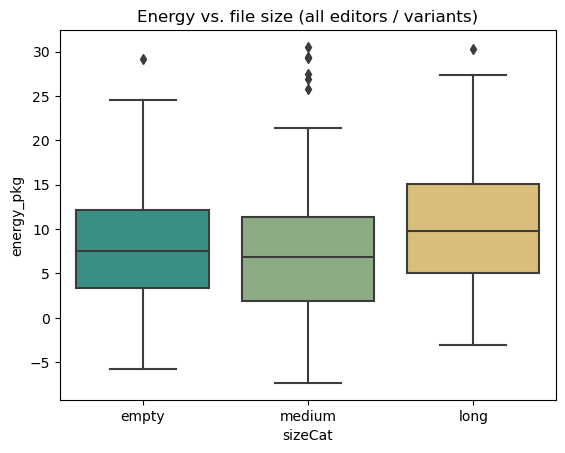

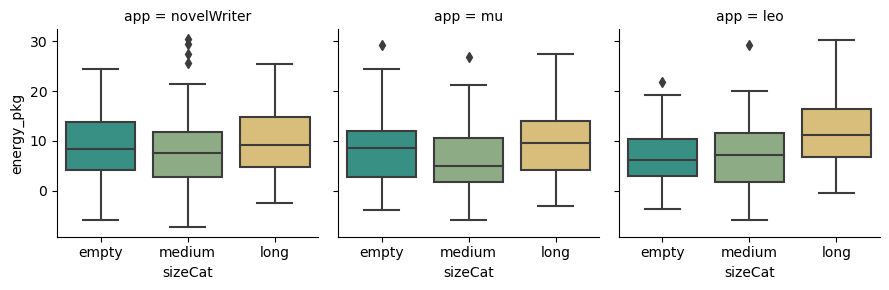

In [167]:
import seaborn as sns
import matplotlib.pyplot as plt

# following website was used https://www.geeksforgeeks.org/boxplot-using-seaborn-in-python/

size_order = pd.CategoricalDtype(['empty', 'medium', 'long'], ordered=True)
app_order  = pd.CategoricalDtype(['novelWriter', 'mu', 'leo'], ordered=True)
df = test_df.copy()
df['sizeCat'] = df['size'].astype(size_order)
df['app']  = df['app'].astype(app_order)
df['sizeNum'] = df['sizeCat'].cat.codes 

sns.boxplot(data=df, x='sizeCat', y='energy_pkg', palette=["#2A9D8F", "#8AB17D", "#E9C46A"])
plt.title('Energy vs. file size (all editors / variants)')
plt.show()

sns.catplot(data=df, x='sizeCat', y='energy_pkg', col='app', col_order=app_order.categories, kind='box', height=3, aspect=1, palette=["#2A9D8F", "#8AB17D", "#E9C46A"])
plt.show()

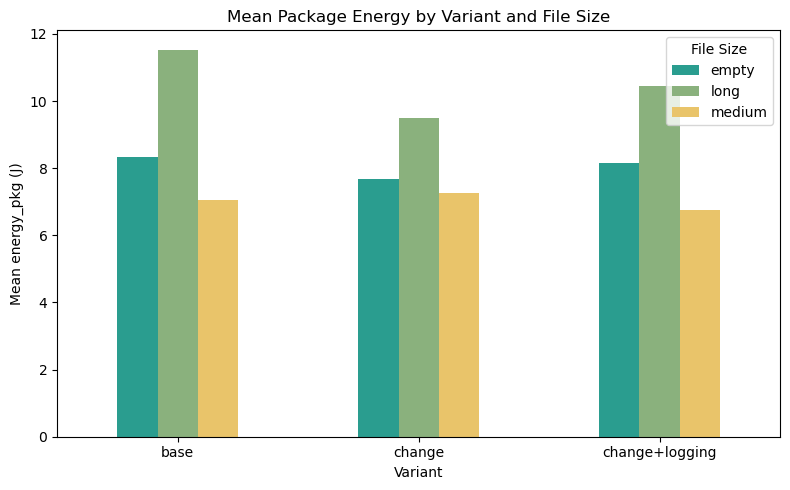

In [161]:
mean_energy = test_df.groupby(['variant', 'size'])['energy_pkg'].mean().unstack('size')

fig, ax = plt.subplots(figsize=(8, 5))
mean_energy.plot(kind='bar', ax=ax, color=["#2A9D8F", "#8AB17D", "#E9C46A"])
ax.set_xlabel('Variant')
ax.set_ylabel('Mean energy_pkg (J)')
ax.set_title('Mean Package Energy by Variant and File Size')
ax.legend(title='File Size')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [145]:
mean_energy

size,empty,long,medium
variant,,,
base,8.324801,11.529364,7.057271
change,7.671189,9.493393,7.269348
change+logging,8.163678,10.450222,6.748098


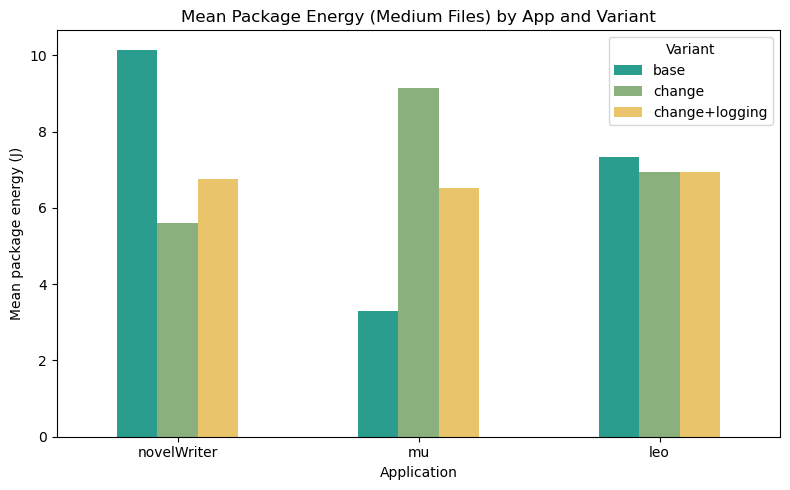

In [163]:
# GPT consulted on how to fix the order of the applications in the diagram

medium_df = test_df[test_df['size'] == 'medium']
order = ['novelWriter', 'mu', 'leo']

mean_energy = medium_df.groupby(['app', 'variant'])['energy_pkg'].mean().unstack('variant')
mean_energy = mean_energy.reindex(order)
fig, ax = plt.subplots(figsize=(8, 5))
mean_energy.plot(kind='bar', ax=ax, color=["#2A9D8F", "#8AB17D", "#E9C46A"])

ax.set_xlabel("Application")
ax.set_ylabel("Mean package energy (J)")
ax.set_title("Mean Package Energy (Medium Files) by App and Variant")
ax.legend(title="Variant")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [147]:
test_df

,energy_pkg,energy_cores,cycles,instructions,cache_references,cache_misses,cs,migrations,page_faults,test,run,app,variant,size
0,10.382667,0.057667,-6.404795e+07,-1.221639e+08,4.056103e+06,1.786671e+06,1090.6,-4.233333,-154.366667,test_leo_skeleton_base_empty,1,leo,base,empty
1,-2.227333,-0.152333,-9.735189e+07,-1.840797e+08,1.339776e+06,8.686906e+05,810.6,-22.233333,-1073.366667,test_leo_skeleton_base_empty,2,leo,base,empty
2,5.452667,-0.232333,-1.238670e+08,-1.791475e+08,8.759928e+05,8.454926e+05,685.6,1.766667,-401.366667,test_leo_skeleton_base_empty,3,leo,base,empty
3,8.432667,0.217667,1.930030e+07,-1.687470e+08,4.344281e+06,2.226614e+06,1283.6,-8.233333,-1098.366667,test_leo_skeleton_base_empty,4,leo,base,empty
4,13.502667,0.067667,2.658292e+07,-7.803483e+05,3.773653e+06,1.537452e+06,1333.6,15.766667,1043.633333,test_leo_skeleton_base_empty,5,leo,base,empty
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,4.018667,0.396667,1.852625e+08,3.708032e+07,3.533015e+06,2.049443e+06,1602.7,-113.333333,-384.000000,test_novelWriter_skeleton_change_medium,26,novelWriter,change,medium
716,-5.531333,0.066667,1.220311e+08,6.568050e+07,2.933219e+06,1.085500e+06,1051.7,-81.333333,425.000000,test_novelWriter_skeleton_change_medium,27,novelWriter,change,medium
717,8.478667,0.166667,4.530326e+07,1.194337e+07,-4.401377e+05,9.760995e+05,784.7,-118.333333,-552.000000,test_novelWriter_skeleton_change_medium,28,novelWriter,change,medium
718,4.478667,0.016667,4.402526e+06,6.943424e+06,2.438866e+06,5.175455e+05,742.7,-101.333333,-560.000000,test_novelWriter_skeleton_change_medium,29,novelWriter,change,medium


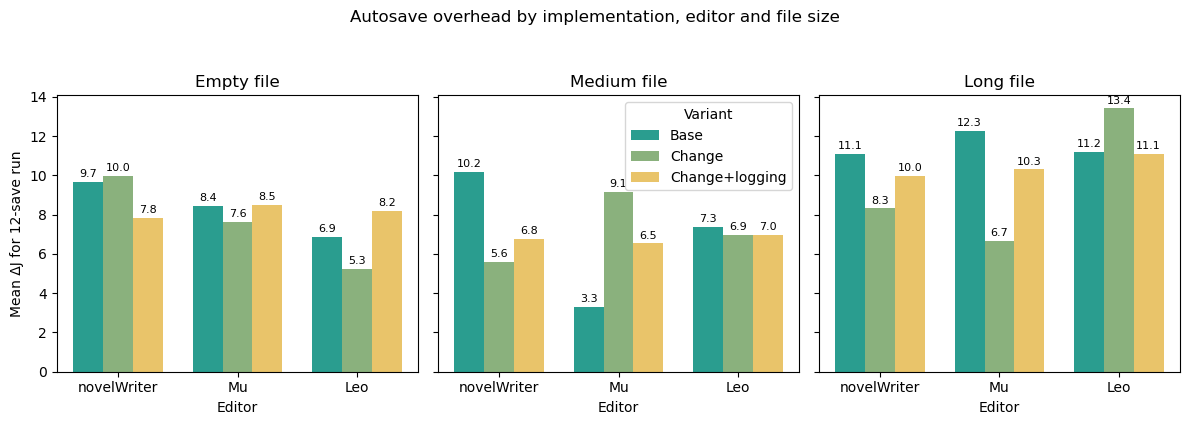

In [152]:
df = test_df.copy()
df['delta_pkg'] = df['energy_pkg']

order_sizes = ['empty', 'medium', 'long']
order_editors = ['novelWriter', 'mu', 'leo']
order_variants = ['base', 'change', 'change+logging']
colors = ["#2A9D8F", "#8AB17D", "#E9C46A"]
bar_width = 1

# A lot of help was used by GPT for the diagram below

g = (df.groupby(['size', 'app', 'variant'])['delta_pkg'].mean().reindex(
           pd.MultiIndex.from_product(
               [order_sizes, order_editors, order_variants],
               names=['size', 'app', 'variant']
           )
       )
       .reset_index())

fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

for ax, sz in zip(axs, order_sizes):
    subset = g[g['size'] == sz]

    for i, editor in enumerate(order_editors):
        heights = (subset[subset['app'] == editor]
                   .set_index('variant')
                   .loc[order_variants, 'delta_pkg']
                   .values)
        x_base = i * 4

        for j, (variant, h) in enumerate(zip(order_variants, heights)):
            bar = ax.bar(x_base + j, h,
                         width=bar_width,
                         color=colors[j],
                         label=variant.capitalize() if i == 0 else None)
            ax.text(x_base + j, h + 0.15,
                    f'{h:.1f}',
                    ha='center', va='bottom', fontsize=8)

    ax.set_title(f'{sz.capitalize()} file')
    ax.set_xticks([i * 4 + 1 for i in range(len(order_editors))])
    ax.set_xticklabels(['novelWriter', 'Mu', 'Leo'])
    ax.set_xlabel('Editor')

axs[0].set_ylabel('Mean ΔJ for 12-save run')
fig.suptitle('Autosave overhead by implementation, editor and file size', y=1.05)
axs[1].legend(title='Variant')
plt.tight_layout()
plt.show()